In [1]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 여기에서 데이터 선택 -> 자동화 부탁

In [3]:
total_df = pd.read_csv('../../data/merged_final.csv', index_col=0)

In [5]:
def sample_multivariate(amount, total_df, target_df_columns):
    samples = []
    # 데이터프레임을 하나로 통합
    df = total_df[target_df_columns]
    columns = df.columns
    if amount == 0:
        # y값만 리턴
        samples.append(df)
    elif amount == 1:
        # sample을 한 column씩 추출
        for index in range(len(columns) - 1):
            sample = df[[columns[index], columns[-1]]]
            samples.append(sample)
    elif amount == 2:
        # sample을 두 column씩 추출
        for first_index in range(len(columns)-1):
            remaining_columns = columns[first_index+1:-1]
            for second_index in range(len(remaining_columns)):
                targets = [columns[first_index],remaining_columns[second_index],columns[-1]]
                sample = df[targets]
                samples.append(sample)
    return samples

In [6]:
def split_sample(df):
    train = df.iloc[:1096]
    test = df.iloc[1096:]
    return {"train":train, "test":test}

In [7]:
samples = sample_multivariate(1,total_df,['air_GW', 'real_pop_GW', 'pop_GW', 'pop_male_GW', 'pop_female_GW',
       'mvpop_GW', 'station_GW', 'GW_demand'])

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()


In [10]:
scaled = []
for sample in samples:
    train_set = split_sample(sample)["train"]
    test_set = split_sample(sample)["test"]
    # Input scale
    scaler_x.fit(sample.iloc[:, :-1])
    train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
    test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])
    # Output scale
    scaler_y.fit(train_set.iloc[:, [-1]])
    train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
    test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])
    scaled.append({"train":train_set,"test":test_set})
samples = scaled



In [11]:
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [12]:
# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

In [13]:
# 설정값
data_dim = len(samples[0]["train"].columns)
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 500

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [14]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [39]:
for index, sample in enumerate(samples):
    
    trainX, trainY = build_dataset(np.array(sample["train"]), seq_length)
    testX, testY = build_dataset(np.array(sample["test"]), seq_length)

    # 텐서로 변환
    trainX_tensor = torch.FloatTensor(trainX)
    trainY_tensor = torch.FloatTensor(trainY)
    testX_tensor = torch.FloatTensor(testX)
    testY_tensor = torch.FloatTensor(testY)

    # 텐서 형태로 데이터 정의
    dataset = TensorDataset(trainX_tensor, trainY_tensor)

    # 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
    dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)
    device = torch.device('cpu')
    net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
    model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

    # 모델 저장    
    PATH = f"./Timeseries_LSTM_data-{index}.pth"
    torch.save(model.state_dict(), PATH)

Epoch: 0000 train loss : 0.0652
Epoch: 0020 train loss : 0.0183

 Early Stopping
Epoch: 0000 train loss : 0.0778
Epoch: 0020 train loss : 0.0172

 Early Stopping
Epoch: 0000 train loss : 0.0655
Epoch: 0020 train loss : 0.0180
Epoch: 0040 train loss : 0.0170

 Early Stopping
Epoch: 0000 train loss : 0.0913
Epoch: 0020 train loss : 0.0177
Epoch: 0040 train loss : 0.0180

 Early Stopping
Epoch: 0000 train loss : 0.0848
Epoch: 0020 train loss : 0.0178
Epoch: 0040 train loss : 0.0172
Epoch: 0060 train loss : 0.0176

 Early Stopping
Epoch: 0000 train loss : 0.0690
Epoch: 0020 train loss : 0.0171

 Early Stopping
Epoch: 0000 train loss : 0.0769
Epoch: 0020 train loss : 0.0180

 Early Stopping


In [40]:
# epoch별 손실값
# fig = plt.figure(figsize=(10, 4))
# plt.plot(train_hist, label="Training loss")
# plt.legend()
# plt.show()

In [43]:
# 불러오기
PATH = "./Timeseries_LSTM_data-6.pth"
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(2, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [101]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()
        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

AttributeError: 'list' object has no attribute 'dim'

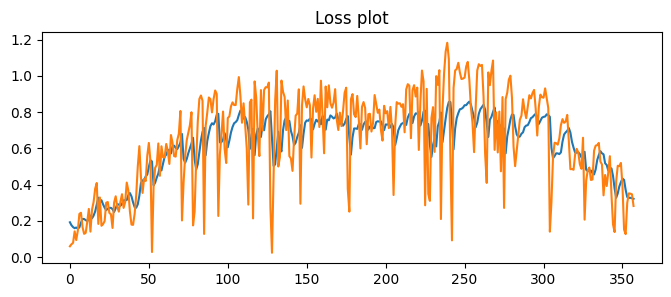

In [35]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred)), pred, label = 'pred')
plt.plot(np.arange(len(testY)), testY, label = 'true')
plt.title("Loss plot")
plt.show()

In [77]:
to_test = total_df[['station_GW',total_df.columns[-4]]]
to_test = split_sample(to_test)

In [78]:
to_test


{'train':       station_GW  GW_demand
 0             37      0.592
 1             37      0.840
 2             37      0.828
 3             37      0.792
 4             37      0.818
 ...          ...        ...
 1091          78      3.528
 1092          78      4.542
 1093          78      3.694
 1094          78      2.366
 1095          78      2.366
 
 [1096 rows x 2 columns],
 'test':       station_GW  GW_demand
 1096          78      2.070
 1097          78      2.062
 1098          78      1.918
 1099          78      3.238
 1100          78      2.864
 ...          ...        ...
 1456          86      3.830
 1457          86      4.510
 1458          86      4.490
 1459          86      4.444
 1460          86      3.616
 
 [365 rows x 2 columns]}

In [79]:
train_set2 = to_test["train"]
test_set2 = to_test["test"]

In [152]:

# Input scale
scaler_x.fit(test_set2.iloc[:, :-1])
train_set2.iloc[:, :-1] = scaler_x.transform(train_set2.iloc[:, :-1])
test_set2.iloc[:, :-1] = scaler_x.transform(test_set2.iloc[:, :-1])
# Output scale
scaler_y.fit(train_set2.iloc[:, [-1]])
train_set2.iloc[:, -1] = scaler_y.transform(train_set2.iloc[:, [-1]])
test_set2.iloc[:, -1] = scaler_y.transform(test_set2.iloc[:, [-1]])


In [153]:
amount = 2
empty = pd.DataFrame({"station_GW":[1]*amount,"GW_demand":[0]*amount})
empty
test_set3 = pd.concat([test_set2.iloc[-7:],empty],ignore_index=True)
test_set3

,station_GW,GW_demand
0,1.0,0.151534
1,1.0,0.126149
2,1.0,0.298240
3,1.0,0.351191
4,1.0,0.349634
5,1.0,0.346052
6,1.0,0.281576
7,1.0,0.000000
8,1.0,0.000000
9,1.0,0.000000


In [158]:
testX2, testY2 = build_dataset(np.array(test_set2), seq_length)
testX_tensor_2 = torch.FloatTensor(testX2)
testY_tensor_2 = torch.FloatTensor(testY2)

In [159]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor_2)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor_2[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor_2)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

# pred_inverse
testY_inverse
# print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))



array([[0.05918081],
       [0.07039402],
       [0.07818097],
       [0.14141099],
       [0.09359913],
       [0.1442143 ],
       [0.23796916],
       [0.24419872],
       [0.16461611],
       [0.12801744],
       [0.13315684],
       [0.19529669],
       [0.26537922],
       [0.14016509],
       [0.2616415 ],
       [0.30322379],
       [0.37704408],
       [0.40834761],
       [0.18268183],
       [0.32860926],
       [0.17240305],
       [0.18159166],
       [0.19841146],
       [0.29964179],
       [0.30353528],
       [0.24326429],
       [0.23563308],
       [0.16041115],
       [0.30042049],
       [0.33530602],
       [0.27659243],
       [0.25042829],
       [0.30540416],
       [0.34651923],
       [0.27083009],
       [0.30260083],
       [0.41068369],
       [0.36801121],
       [0.25151846],
       [0.1789441 ],
       [0.1773867 ],
       [0.23828064],
       [0.34137985],
       [0.50085658],
       [0.61189848],
       [0.43980688],
       [0.35383898],
       [0.432